<a href="https://colab.research.google.com/github/david91107/predict_sklearn/blob/main/predictive_modeling_with_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Jupyter notebook, I present a sophisticated AI model designed to identify and quantify the key factors contributing to customer churn in subscription-based services. This model demonstrates my adeptness in leveraging advanced machine learning techniques and data analytics to solve real-world business problems. By meticulously experimenting with various machine learning algorithms, I have developed a model that not only predicts churn with high accuracy but also provides insightful interpretations of the underlying causes. The results shown were implemented to reduce churn by > 15% This project demonstrates my proficiency in Python programming, deep understanding of predictive modeling, and ability to translate complex data insights into actionable business strategies.

# Predictive churn model for a subscription service.


**Notebook Chapters**

Project Introduction

Model Selection

Enviornment Creation

Data Ingestion

Exploratory Data Analysis (EDA)

Model Comparison

Feature Importance

Conclusion and Recommendations


##Project Introduction

The project uses commercial data from a subscription service to indentify factors and their importance in reducing customer service cancellations (aka, "churn"). Where possible, this project will leverage scikit-learn.

##Model Selection

Mutiple models where consdiered for this project. Given the constraints of low compute costs, a small dataset, class imbalanced and the need to identify feature weights, the following models were used:

*   Logistic Regression<br>
Pros: With a small dataset and limited compute resources, logistic regression is a great starting point due to its simplicity and low computational cost. It also provides direct insight into feature importance.<br>
Cons: Its linear nature might not capture complex relationships.<br>
<br>
*   Decision Trees<br>
Pros: They are relatively simple to understand and can provide clear insights into which features are most important in predicting churn.<br>
Cons: Prone to overfitting, especially with small datasets.<br>
<br>
*   Random Forest<br>
Pros: Can handle imbalanced classes better than many models and provides feature importance. It's also less likely to overfit compared to a single decision tree.<br>
Cons: More computationally intensive than logistic regression or a single decision<br>
<br>
*   Gradient Boosting Machines <br>
Pros: Often more effective than random forests, especially with small datasets. Provides feature importance.<br>
Cons: Can be computationally expensive and prone to overfitting.<br>
<br>

Results for all models are shown and compared below.

## Enviornment Creation

In [1]:
# Create python enviornment

# Install libraries

!pip install --upgrade pip
!pip install scikit-learn
!pip install pandas==1.5.3 # to be compatible with google-colab 1.0.0
!pip install matplotlib
!pip install shap

# Install methods

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score, accuracy_score,f1_score

import shap as shap
from shap import TreeExplainer, summary_plot

from sklearn.feature_selection import RFE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 18.3 MB/s eta 0:00:00


##Data Ingestion

In [2]:
# Load CSV data file into a dataframe

df_pre = pd.read_csv(r'/content/drive/MyDrive/Data_sets/telco_subscription_data.csv')

# Check data load

df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   random_key                 134575 non-null  int64  
 1   target                     134575 non-null  int64  
 2   customer_demo_age          134575 non-null  int64  
 3   customer_demo_geography_1  134575 non-null  int64  
 4   customer_demo_geography_2  134575 non-null  int64  
 5   sales_channel              134575 non-null  int64  
 6   sales_team                 134575 non-null  int64  
 7   sales_program              134575 non-null  int64  
 8   product_sku                134575 non-null  int64  
 9   product_cpe                134575 non-null  int64  
 10  product_operations_kpi1    132071 non-null  float64
 11  product_operations_kpi2    134575 non-null  int64  
 12  product_usage_kpi1         134575 non-null  int64  
 13  product_usage_kpi2         13

In [3]:
# Address null values

# Look for Nulls

df_pre.info()

# Drop Nulls

df_pre.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   random_key                 134575 non-null  int64  
 1   target                     134575 non-null  int64  
 2   customer_demo_age          134575 non-null  int64  
 3   customer_demo_geography_1  134575 non-null  int64  
 4   customer_demo_geography_2  134575 non-null  int64  
 5   sales_channel              134575 non-null  int64  
 6   sales_team                 134575 non-null  int64  
 7   sales_program              134575 non-null  int64  
 8   product_sku                134575 non-null  int64  
 9   product_cpe                134575 non-null  int64  
 10  product_operations_kpi1    132071 non-null  float64
 11  product_operations_kpi2    134575 non-null  int64  
 12  product_usage_kpi1         134575 non-null  int64  
 13  product_usage_kpi2         13

In [4]:
# Check for any duplication

print("Number of duplicate rows:", df_pre.duplicated().sum())

Number of duplicate rows: 0


In [5]:
# Some of the int values are actually string values
# that will need to be flattened

columns_to_cast = ['sales_team', 'sales_channel','sales_program','product_sku','product_cpe','customer_demo_geography_1','customer_demo_geography_2']

df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(object)

# Some of the float64 values are actually int values
# that will need to be flattened

# Define a list of column names to cast
columns_to_cast = ['product_operations_kpi1']

# Cast the columns
df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(int)

## Explority Data Analysis

Source data has exensive inbalance, particularly in the target value (boolean for the account status whre 1 = churn, and 0 = active). Features appear to be largely independet as shown by Perason and VIF.

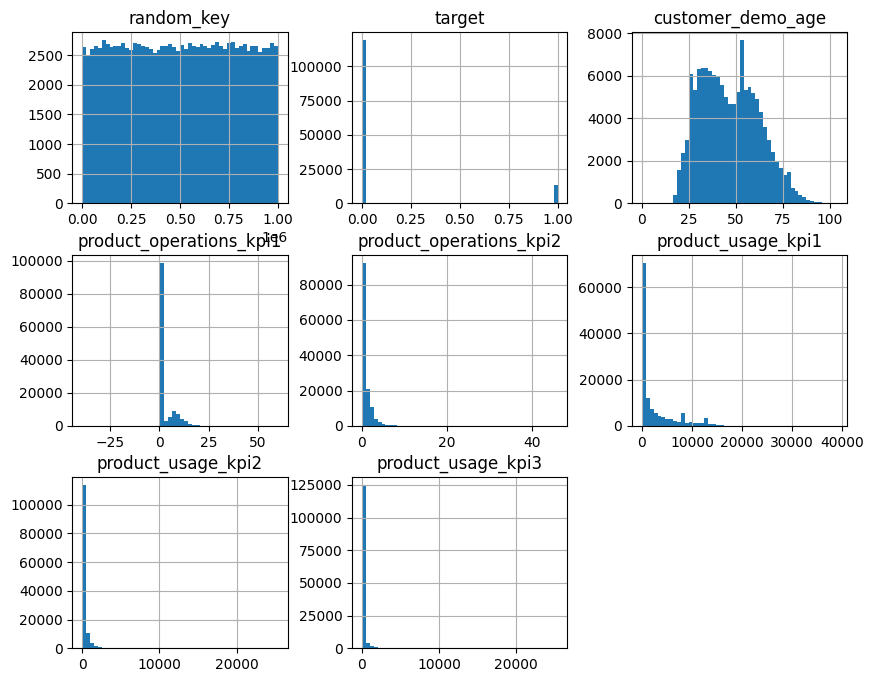

In [6]:
# Exploratory plots

df_pre.hist(bins=50, figsize=(10, 8))
plt.show()

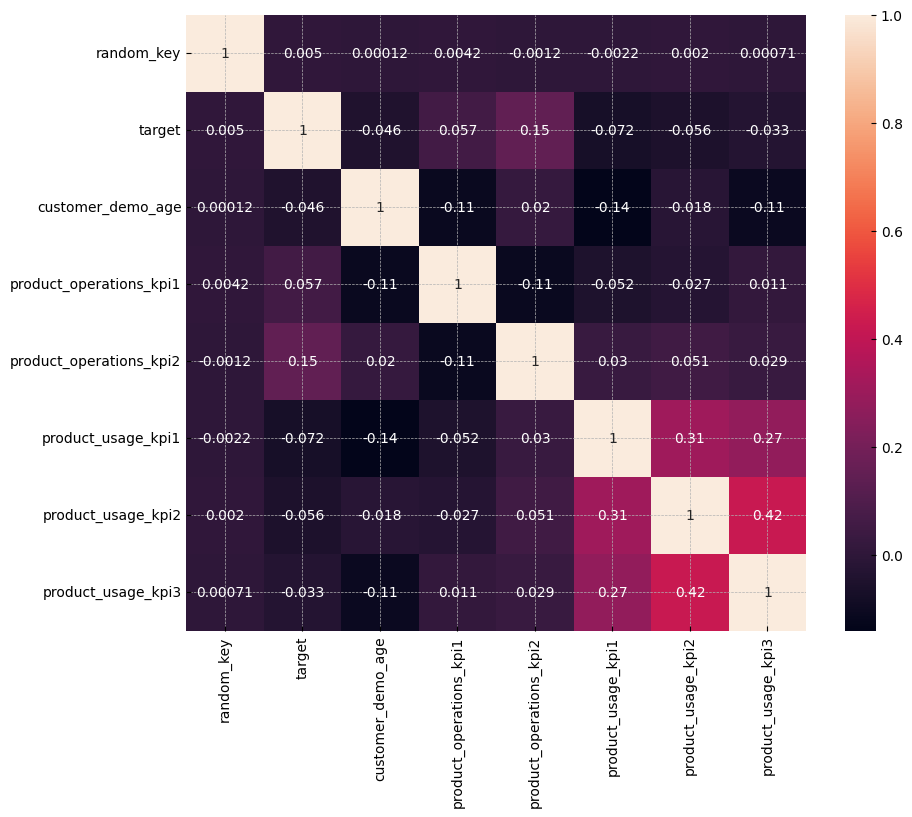

In [7]:
# Collinearity: Pearson

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [8]:
# Collinearity: VIF

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

# Calculate VIF for each numeric feature
vif = pd.DataFrame()
vif["Feature"] = df_num.columns
vif["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Print the VIF values to identify multicollinearity among numeric features
print("VIF Values for Numeric Features:")
print(vif)

VIF Values for Numeric Features:
                   Feature       VIF
0               random_key  3.281181
1                   target  1.140411
2        customer_demo_age  3.585833
3  product_operations_kpi1  1.495137
4  product_operations_kpi2  1.248218
5       product_usage_kpi1  1.589605
6       product_usage_kpi2  1.536839
7       product_usage_kpi3  1.364883


## Prepare Dataset

Preliminary feature reduction efforts require numeric data. Features with string values will be flattened, and features with continuous numeric values will be normalized.

In [9]:
unique_counts_per_column = df_pre.nunique()

print(unique_counts_per_column)

random_key                   123692
target                            2
customer_demo_age                86
customer_demo_geography_1        50
customer_demo_geography_2      5307
sales_channel                     4
sales_team                       22
sales_program                    20
product_sku                       3
product_cpe                      18
product_operations_kpi1          56
product_operations_kpi2          27
product_usage_kpi1            14209
product_usage_kpi2             3439
product_usage_kpi3             2634
dtype: int64


Numerical, continuous data (product_usage_kpi1, product_operations_kpi1) have a high unique count and should not present a problem. However, the categorical features with high unique value counts (customer_demo_geography_2) may be an issue. For how this value will be dropped. After the inital data is analyzed customer_demo_geography_2 will be re-investigated for value.

In [10]:
# Drop features

df_pre.drop(columns='random_key', inplace=True) # used initially to identify duplicates
df_pre.drop(columns='customer_demo_geography_2', inplace=True)

In [11]:
# Normalize continuous features

columns_to_norm = ['product_usage_kpi1','product_usage_kpi2', 'product_usage_kpi3','product_operations_kpi1','product_operations_kpi2']

for column in columns_to_norm:
  df_pre[column] = df_pre[column] / df_pre[column].abs().max()

In [12]:
# Bin age into generations
# Assumption is that trends fall along generations more than specific ages
# https://www.beresfordresearch.com/age-range-by-generation/

df_pre['customer_demo_age_gen'] = df_pre['customer_demo_age'].apply(lambda age:
    'gen_z' if age >= 12 and age <= 27 else
    'millennial' if age >= 28 and age <= 43 else
    'gen_x' if age >= 44 and age <= 59 else
    'boomers' if age >= 60 and age <= 78 else
    'post_war' if age >= 79 and age <= 96 else
    'invalid' if age < 18 and age > 99 else
    'other'
)

# Drop age
df_pre.drop('customer_demo_age', axis=1, inplace=True)

In [13]:
# Flatten categorical features

categorical_features = ['product_sku','sales_channel','sales_team','product_cpe','sales_program','customer_demo_age_gen','customer_demo_geography_1']

# Perform one-hot encoding (flattening) of the specified columns
df_pre = pd.get_dummies(df_pre, columns=categorical_features)

# Convert boolean values to integers (1 and 0)
df_pre = df_pre.astype(int)

In [14]:
# Initial feature counts

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 129


In [ ]:
df_pre.head()

In [15]:
# Perform ANOVA tests for each feature and reduce features

from scipy.stats import f_oneway

alpha = 0.05
anova_results = []
features_to_drop = []
target_variable = 'target'

for feature_column in df_pre.columns:
    if feature_column != target_variable:
        # Group data by target variable and perform ANOVA
        grouped_data = [group[1] for group in df_pre.groupby(target_variable)[feature_column]]
        f_statistic, p_value = f_oneway(*grouped_data)
        if p_value >= alpha:
            significance = 'Not Significant'
            features_to_drop.append(feature_column)
        else:
            significance = 'Significant'

        # Store the results
        anova_results.append([feature_column, f_statistic, p_value, significance])

# Drop non-significant features
df_pre.drop(columns=features_to_drop, inplace=True)

In [ ]:
df_pre.head()

In [16]:
# Additional Feature Reduction with Recursive Feature Elimination (RFE)

from sklearn.tree import DecisionTreeClassifier

# Extract the target variable and create X and y
y = df_pre['target']
X = df_pre.drop(columns=['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the number of features to select (you can adjust this)
num_features_to_select = 12

# Create the RFE model
rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

# Fit the RFE model to the training data
rfe.fit(X_train, y_train)

# Get the selected feature names
selected_feature_names = X.columns[rfe.support_]

# Print the names of the selected features
print("Selected feature names:", selected_feature_names.tolist())

# Filter both the training and test sets using the selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Train and evaluate your model using the selected features and the test data
clf.fit(X_train_selected, y_train)
accuracy = clf.score(X_test_selected, y_test)
print(f"Accuracy on test data with selected features: {accuracy:.2f}")

# Create a final DataFrame including the selected features and the target variable
df_final = df_pre[selected_feature_names].copy()
df_final['target'] = y


Selected feature names: ['product_sku_0', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'sales_team_17', 'product_cpe_6', 'product_cpe_7', 'sales_program_8', 'sales_program_18', 'customer_demo_age_gen_boomers', 'customer_demo_geography_1_3', 'customer_demo_geography_1_8']
Accuracy on test data with selected features: 0.90


In [ ]:
df_final.info()

In [17]:
# Feature count after reduction

unique_column_names = set(df_final.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 13


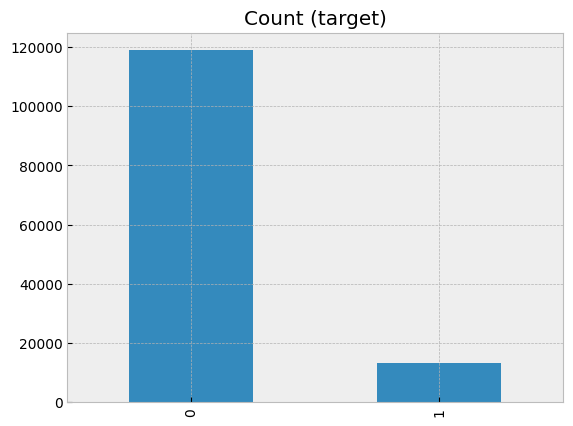

<Figure size 1000x800 with 0 Axes>

In [18]:
# Address class imbalance of the target

df_final.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

Random over-sampling:
0    118901
1    118901
Name: target, dtype: int64


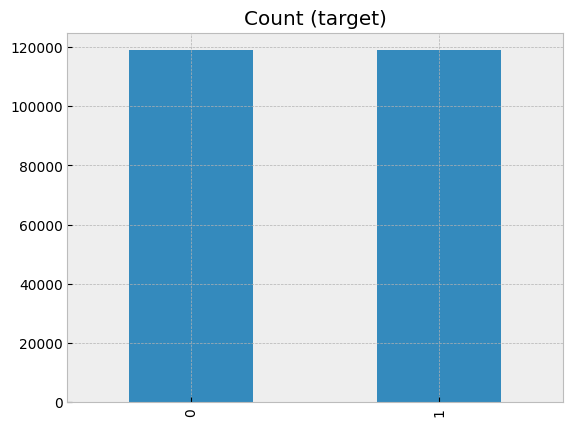

<Figure size 1000x800 with 0 Axes>

In [19]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpetation of
# feature importance.

count_class_0, count_class_1 = df_final.target.value_counts()

# Divide by class
df_class_0 = df_final[df_final['target'] == 0] #majority class
df_class_1 = df_final[df_final['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

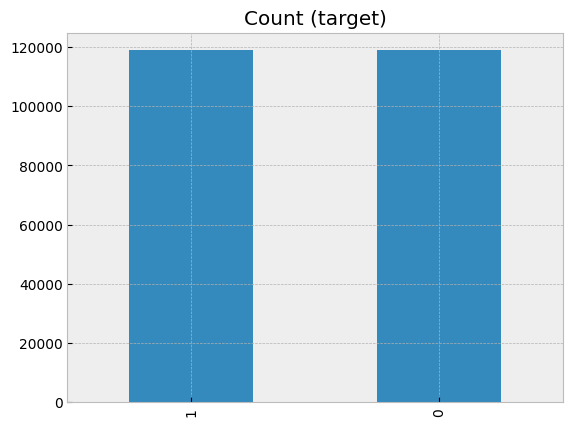

In [20]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [21]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)#, random_state=42)

##Model Comparison


### Logistic Regression

In [22]:
# Create model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [23]:
# Fit and score the model

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [24]:
# Confusion matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     23729
           1       0.72      0.78      0.75     23832

    accuracy                           0.74     47561
   macro avg       0.74      0.74      0.74     47561
weighted avg       0.74      0.74      0.74     47561



C=0.0001, train: 0.727, test: 0.726
C=0.0003, train: 0.733, test: 0.732
C=0.0007, train: 0.736, test: 0.734
C=0.0018, train: 0.736, test: 0.734
C=0.0048, train: 0.737, test: 0.736
C=0.0127, train: 0.745, test: 0.742
C=0.0336, train: 0.744, test: 0.742
C=0.0886, train: 0.744, test: 0.742
C=0.2336, train: 0.744, test: 0.742
C=0.6158, train: 0.744, test: 0.742
C=1.6238, train: 0.744, test: 0.742
C=4.2813, train: 0.744, test: 0.742
C=11.2884, train: 0.744, test: 0.742
C=29.7635, train: 0.744, test: 0.742
C=78.4760, train: 0.744, test: 0.742
C=206.9138, train: 0.744, test: 0.742
C=545.5595, train: 0.744, test: 0.742
C=1438.4499, train: 0.744, test: 0.742
C=3792.6902, train: 0.744, test: 0.742
C=10000.0000, train: 0.744, test: 0.742


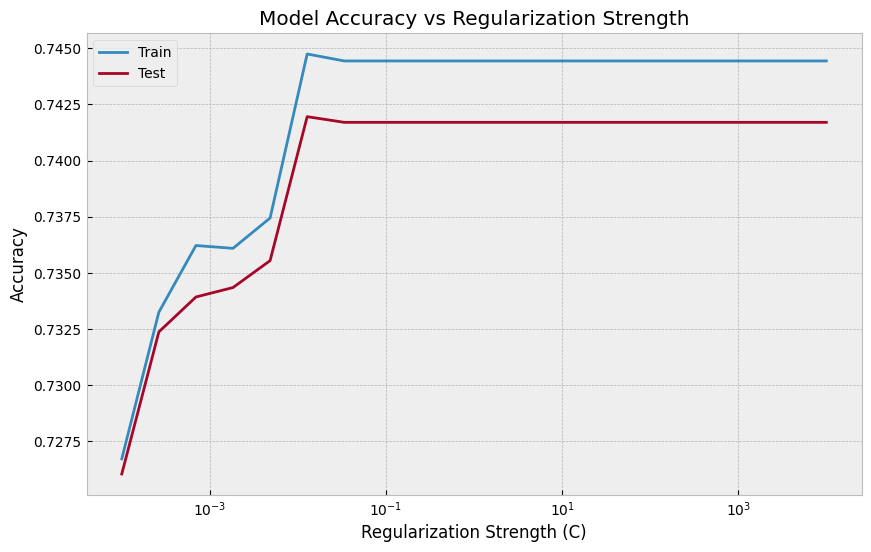

In [26]:
# Look for overfitting

# Define the regularization strengths to evaluate
C_values = np.logspace(-4, 4, 20)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each regularization strength
for C in C_values:

    # Configure the model
    model = LogisticRegression(C=C, max_iter=1000)

    # Fit model on the training dataset
    model.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('C=%.4f, train: %.3f, test: %.3f' % (C, train_acc, test_acc))

# Plot of train and test scores vs regularization strength
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_scores, label='Train')
plt.semilogx(C_values, test_scores, label='Test')
plt.title('Model Accuracy vs Regularization Strength')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [27]:
# Define hyperparameter dictionary for Logistic Regression

param_dict = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize Logistic Regression
log_reg = LogisticRegression()

# Set up GridSearchCV
grid = GridSearchCV(estimator=log_reg,
                    param_grid=param_dict,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

# Fit GridSearchCV to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [28]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'C': 0.0018329807108324356, 'penalty': 'l1', 'solver': 'saga'}

In [30]:
# Update model

model_u=LogisticRegression(C = 0.0018329807108324356,
                                   penalty ='l1',
                                   solver = 'saga')

In [31]:
#Fit and re-score the model

model_u.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_u.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


Churn: ROC AUC=0.500
Logistic: ROC AUC=0.789


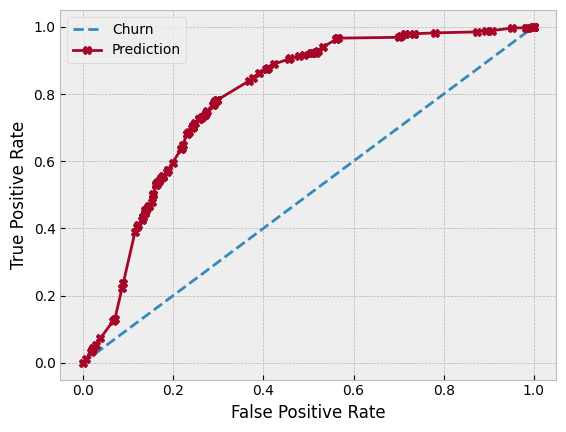

In [32]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

###Decision Tree Classification

In [33]:
# Create model

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [34]:
# Fit and score the model

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [35]:
# Confusion matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.67      0.73     23729
           1       0.72      0.82      0.76     23832

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.74     47561
weighted avg       0.75      0.75      0.74     47561



>1, train: 0.719, test: 0.717
>2, train: 0.737, test: 0.735
>3, train: 0.737, test: 0.735
>4, train: 0.740, test: 0.739
>5, train: 0.744, test: 0.741
>6, train: 0.749, test: 0.744
>7, train: 0.750, test: 0.746
>8, train: 0.751, test: 0.746
>9, train: 0.751, test: 0.746
>10, train: 0.751, test: 0.746
>11, train: 0.751, test: 0.746
>12, train: 0.751, test: 0.746
>13, train: 0.751, test: 0.746
>14, train: 0.751, test: 0.746


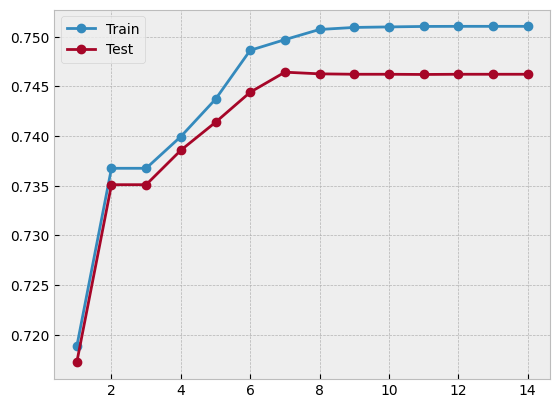

In [54]:
# Look for overfitting

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [37]:
# Get model parameters

model = DecisionTreeClassifier()
for parameter in model.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
random_state
splitter


In [40]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {'criterion' :['gini', 'entropy'],
            'max_depth' :range(1,8),
            'min_samples_split': [20, 50],
            'min_samples_leaf': [20, 50],
            'ccp_alpha': [0.0001, 0.001]
              }

tree_class = DecisionTreeClassifier()


grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 8), 'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [41]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

In [47]:
# Update model

model_u=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 5,
                                   min_samples_split = 20,
                                   min_samples_leaf = 20)

In [48]:
#Fit and re-score the model

model_u.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_u.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [49]:
# Confusion matrix

y_pred = model_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     23729
           1       0.74      0.75      0.75     23832

    accuracy                           0.74     47561
   macro avg       0.74      0.74      0.74     47561
weighted avg       0.74      0.74      0.74     47561



>1, train: 0.719, test: 0.717
>2, train: 0.737, test: 0.735
>3, train: 0.737, test: 0.735
>4, train: 0.740, test: 0.739
>5, train: 0.744, test: 0.741


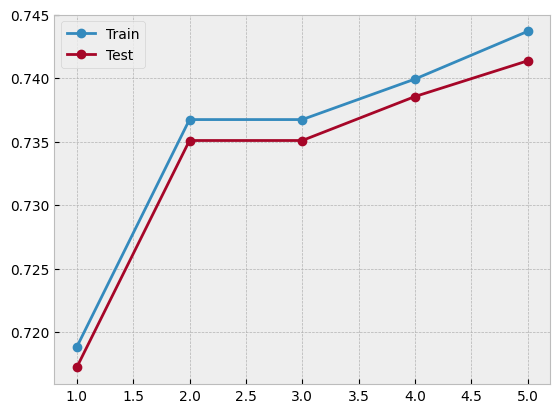

In [52]:
# Look again for overfitting via Accuracy

# Define the tree depths to evaluate
values = [i for i in range(1, 6)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_u = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model_u.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_u.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_u.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Churn: ROC AUC=0.500
Logistic: ROC AUC=0.827


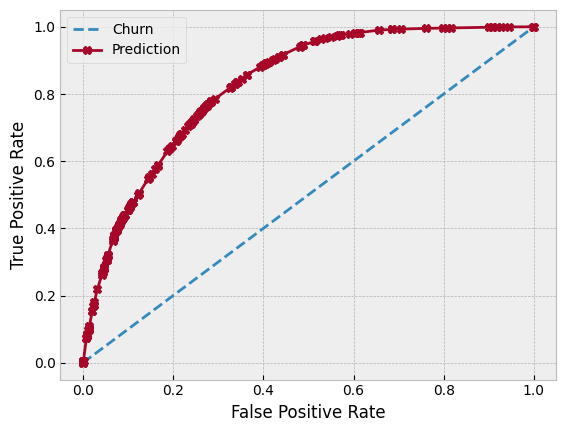

In [46]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### Random Forrest Classifier

In [55]:
# Create model

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [56]:
# Fit and score the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [57]:
# Confusion matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.67      0.73     23729
           1       0.72      0.82      0.76     23832

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.74     47561
weighted avg       0.75      0.75      0.74     47561



Max depth: 1, Train Accuracy: 0.719, Test Accuracy: 0.718
Max depth: 2, Train Accuracy: 0.728, Test Accuracy: 0.727
Max depth: 3, Train Accuracy: 0.736, Test Accuracy: 0.734
Max depth: 4, Train Accuracy: 0.747, Test Accuracy: 0.745
Max depth: 5, Train Accuracy: 0.748, Test Accuracy: 0.745
Max depth: 6, Train Accuracy: 0.747, Test Accuracy: 0.745
Max depth: 7, Train Accuracy: 0.749, Test Accuracy: 0.746
Max depth: 8, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 9, Train Accuracy: 0.751, Test Accuracy: 0.746


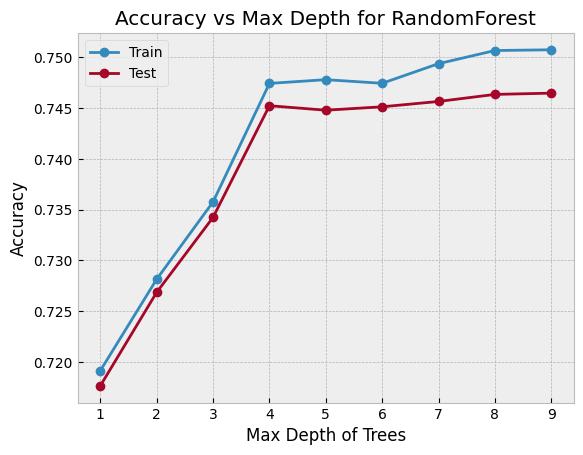

In [58]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 10)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model = RandomForestClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


In [59]:
# Get model parameters

for parameter in model.get_params():
    print(parameter)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [60]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4],
    'min_samples_split': [20, 50],
    'min_samples_leaf': [20, 50],
    'max_features': ['auto', 'sqrt'],
    'ccp_alpha': [0.0001, 0.001]
}

tree_class = RandomForestClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [61]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'min_samples_split': 20}

In [62]:
# Update model

model_u = RandomForestClassifier(
                                  ccp_alpha = 0.001,
                                   criterion ='gini',
                                   max_depth = 4,
                                   max_features = 'auto',
                                   min_samples_leaf = 50,
                                   min_samples_split = 20)

In [63]:
#Fit and re-score the model

model_u.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_u.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [64]:
# Confusion matrix

y_pred = model_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.62      0.70     23729
           1       0.69      0.85      0.76     23832

    accuracy                           0.74     47561
   macro avg       0.75      0.74      0.73     47561
weighted avg       0.75      0.74      0.73     47561



Max depth: 1, Train Accuracy: 0.719, Test Accuracy: 0.718
Max depth: 2, Train Accuracy: 0.728, Test Accuracy: 0.727
Max depth: 3, Train Accuracy: 0.736, Test Accuracy: 0.734
Max depth: 4, Train Accuracy: 0.747, Test Accuracy: 0.745
Max depth: 5, Train Accuracy: 0.748, Test Accuracy: 0.745
Max depth: 6, Train Accuracy: 0.747, Test Accuracy: 0.745
Max depth: 7, Train Accuracy: 0.749, Test Accuracy: 0.746
Max depth: 8, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 9, Train Accuracy: 0.751, Test Accuracy: 0.746


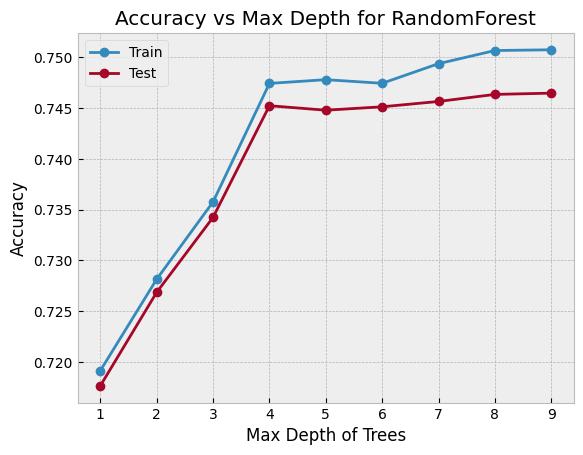

In [67]:
# Look again for overfitting via Accuracy

# Define the tree depths to evaluate
values = range(1, 10)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_u = RandomForestClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model_u.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_u.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_u.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


Churn: ROC AUC=0.500
Logistic: ROC AUC=0.827


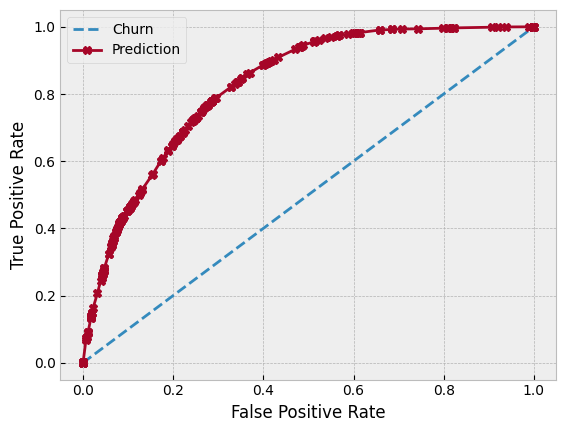

In [68]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

## Gradient Boost


In [69]:
# Create model

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

In [70]:
# Fit and score the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [71]:
# Confusion matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.68      0.73     23729
           1       0.72      0.81      0.76     23832

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.74     47561
weighted avg       0.75      0.75      0.74     47561



Max depth: 1, Train Accuracy: 0.744, Test Accuracy: 0.742
Max depth: 2, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 3, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 4, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 5, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 6, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 7, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 8, Train Accuracy: 0.751, Test Accuracy: 0.746
Max depth: 9, Train Accuracy: 0.751, Test Accuracy: 0.746


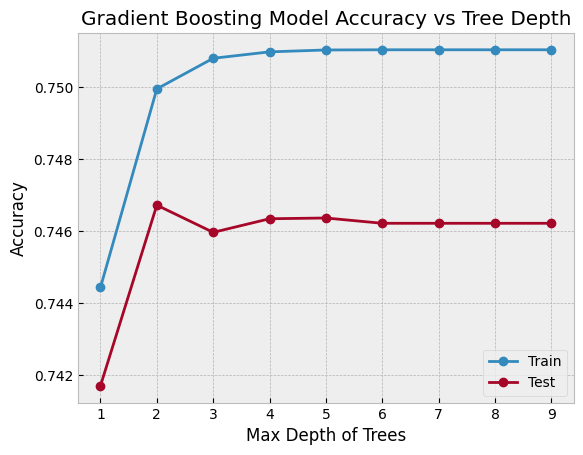

In [72]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 10)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Initialize the Gradient Boosting Classifier with varying max_depth
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=i, random_state=0)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Model Accuracy vs Tree Depth')
plt.legend()
plt.show()


In [74]:
# Get model parameters

for parameter in model.get_params():
    print(parameter)

ccp_alpha
criterion
init
learning_rate
loss
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_iter_no_change
random_state
subsample
tol
validation_fraction
verbose
warm_start


In [75]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {"criterion" :["friedman_mse", "squared_error"],
             'max_depth': [3, 4],
             'min_samples_split': [20, 50],
              'min_samples_leaf': [20, 50],
              'ccp_alpha': [0.0001, 0.001]
              }

tree_class = GradientBoostingClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [3, 4], 'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [76]:
# Extract the best preforming tested parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'friedman_mse',
 'max_depth': 4,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

In [77]:
# Update model

model_u = GradientBoostingClassifier(ccp_alpha = 0.0001,
                                   criterion ='friedman_mse',
                                   max_depth = 4,
                                   min_samples_split = 20,
                                   min_samples_leaf = 20)

In [78]:
#Fit and re-score the model

model_u.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_u.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [79]:
# Confusion matrix

y_pred = model_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.69      0.73     23729
           1       0.72      0.79      0.76     23832

    accuracy                           0.74     47561
   macro avg       0.75      0.74      0.74     47561
weighted avg       0.75      0.74      0.74     47561



Churn: ROC AUC=0.500
Logistic: ROC AUC=0.822


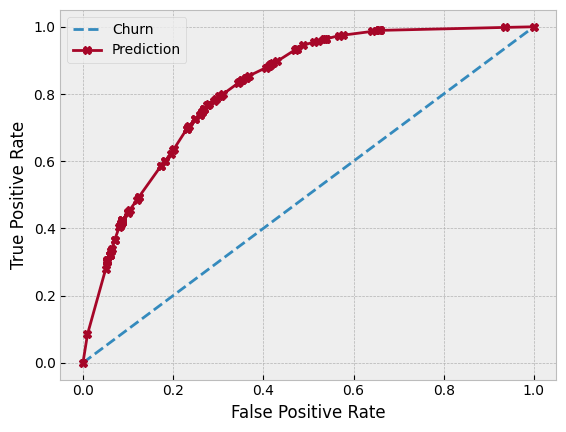

In [80]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
model_u.fit(X_train, y_train.values)

# predict probabilities
lr_probs = model_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

##Feature Importance

In [ ]:
# Print Global SHAP values

exp = TreeExplainer(model_dtc)
sv = exp.shap_values(X_test)

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped


    # Append the statistics to the list of features to drop
    # if 1==1:#not (min_val == mean_val == max_val == 0):
    if (min_val == mean_val == max_val == 0):
        feature_to_drop.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped

# Create a DataFrames of all feature with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_stats.csv'

# Save the DataFrame to the specified path as a CSV file
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Create a DataFrames of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_to_drop_df.csv'

# Save the DataFrame to the specified path as a CSV file
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Plots
# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=20)

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)


In [ ]:
# Force Plot visualization: single customer (Local SHAP values)

# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[120]) # Good Exxample of really bad churn

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend
plt.figure(figsize=(40, 10))  # You can adjust the size as needed
shap.force_plot(exp.expected_value[1], shap_values_single[1], X_test.iloc[0], feature_names=X_test.columns, matplotlib=True)
plt.show()


In [ ]:
# Filter customers based on all specified features and values simultaneously

high_value_features = {
    "product_cpe_6": 1,
    "product_sku_2": 1
    #"sales_team_3": 1
    #"customer_demo_age_gen_boomers" : 1
    #"sales_program_18" : 1
                       }

filtered_customers = X_test.copy()

for feature, value in high_value_features.items():
    filtered_customers = filtered_customers[filtered_customers[feature] == value]

# DataFrame to store SHAP values
shap_values_df = pd.DataFrame()

# Iterate over filtered customers to calculate SHAP values and generate force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Append the SHAP values to the DataFrame
    shap_row_df = pd.DataFrame([shap_values_example[1]], columns=[f'shap_{col}' for col in X_test.columns])
    shap_values_df = pd.concat([shap_values_df, shap_row_df], ignore_index=True)

    # Generate a force plot for the example
    shap.initjs()
    shap.force_plot(exp.expected_value[1], shap_values_example[1], row, matplotlib=True)
    plt.show()

# Concatenate the SHAP values DataFrame with the filtered customers DataFrame
final_df = pd.concat([filtered_customers.reset_index(drop=True), shap_values_df], axis=1)

# Export to CSV
final_df.to_csv('shap_values.csv', index=False)

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

# Train a decision tree model
model = DecisionTreeClassifier(max_depth=3)  # Limit depth for visualization
model.fit(X_train, y_train)

# Export as dot file
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],  # Assuming binary classification with classes '0' and '1'
                           filled=True, rounded=True,
                           special_characters=True,
                           proportion=False,  # Set to 'True' to show percentages instead of sample counts
                           precision=2,  # Set precision for floating point numbers
                           label='all',  # Use 'root' to show labels at the root node or 'all' to show at all nodes
                           leaves_parallel=False)  # Set to 'True' to align leaf nodes horizontally

# Create graph from dot data
graph = graphviz.Source(dot_data)

# Render and show the graph
Image(graph.pipe(format='png'))


In [ ]:
# Feature Importance from the Gradient model

feature_importances = model_gb.feature_importances_

# To display feature importance
for i, feature in enumerate(X_train.columns):
    print(f'Feature: {feature}, Importance: {feature_importances[i]}')

##Model Interpretation and Insights

##Conclusion and Recommendations

## Appendix

Selecting the appropriate value to plot train vs test to indenitfy potential ofverfitting.

**Accuracy**
<br>
<br>
Pros:
<br>
Simplicity: Accuracy is straightforward to understand and interpret. It's the percentage of correctly classified instances out of all instances.
Usefulness in Balanced Datasets: In cases where classes are balanced, accuracy can be a reliable measure of model performance.
<br>
<br>
Cons:
<br>
Misleading in Imbalanced Datasets: In situations where there is a significant class imbalance, accuracy can be misleading. A model could predict the majority class for all instances and still achieve high accuracy.
No Insight into Type I/II Errors: Accuracy doesn't distinguish between the types of errors (false positives and false negatives).
<br>
<br>
**F1-Score**
<br>
<br>
Pros:
<br>
Balance Between Precision and Recall: F1-score provides a balance between precision and recall. It is especially useful in cases where we need to balance false positives and false negatives.
Better for Imbalanced Datasets: It is more informative than accuracy in case of an imbalanced dataset.
<br>
<br>
Cons:
<br>
More Complex to Understand: F1-score is not as intuitive as accuracy, especially for non-technical stakeholders.
Not a Single Error Type Focus: If your specific problem requires optimizing specifically for either precision or recall (but not both), F1-score might not be the best metric.
<br>
<br>
**ROC-AUC**
<br>
<br>
Pros:
<br>
Performance Across Thresholds: AUC-ROC measures the model's performance across all classification thresholds, providing a comprehensive view of its effectiveness.
Useful for Imbalanced Datasets: Like F1-score, it is more informative than accuracy for imbalanced classes.
<br>
<br>
Cons:
<br>
Can Be Overly Optimistic: In highly imbalanced datasets, ROC-AUC might present an overly optimistic view of the model’s performance.
Complexity in Interpretation: Understanding and explaining ROC curves and AUC can be more complex compared to straightforward metrics like accuracy.

Gini Impurity
Pros:

Faster Computation: Gini impurity is computationally less intensive as it doesn't involve logarithmic calculations, which can be advantageous for large datasets.
Performance: It tends to work well in practice and is the default in many decision tree algorithms, like in scikit-learn's DecisionTreeClassifier.
Cons:

Less Sensitive to Changes in Class Probabilities: Gini impurity might be less sensitive to probability changes of the minority class, as it squares the probability terms.
Entropy (Information Gain)
Pros:

Sensitivity to Class Probability Changes: Entropy is more sensitive to changes in the class probabilities of the nodes, potentially leading to more balanced trees.
Information Theoretic Model: It has a basis in information theory, providing a clear interpretation in terms of information content and uncertainty.
Cons:

Computational Intensity: Calculating entropy involves logarithmic computations, which can be more computationally intensive than Gini impurity, especially for very large datasets.
Can Lead to Overfitting: In some cases, because entropy is more sensitive to class probabilities, it can lead to models that are more complex and potentially overfitted.

Bayesian-Optimization Library:

Pro: Offers a probabilistic model that can efficiently find the optimal parameters, especially useful when the number of experiments is limited.
Con: Might be less efficient in high-dimensional space and requires careful choice of the prior.
Scikit-Optimize:

Pro: Integrates seamlessly with scikit-learn and offers several methods including Bayesian optimization, which is useful for optimizing expensive-to-evaluate functions.
Con: Limited to optimization tasks and might not be as scalable as some other libraries.
GPyOpt:

Pro: Built on Gaussian Process models, it is excellent for fine-tuning where evaluations of the function are expensive.
Con: Can be slower and less practical for large-scale hyperparameter optimization due to the computational cost of Gaussian Processes.
Hyperopt:

Pro: Uses Bayesian optimization and supports parallelization, making it efficient for large searches.
Con: Can be complex to configure and understand, especially for beginners.
SHERPA:

Pro: Designed for hyperparameter tuning of machine learning models, supports a variety of algorithms, and is easy to use.
Con: Might not offer as wide a range of optimization algorithms compared to some other tools.
Optuna:

Pro: A modern library with an easy-to-use interface, it offers efficient and flexible optimization with visualization features.
Con: Its flexibility might come at the cost of a steeper learning curve for advanced features.
Ray Tune:

Pro: Highly scalable, supports a wide range of optimization algorithms, and integrates well with deep learning frameworks.
Con: Its broad functionality can make it more complex to set up and use.
Neural Network Intelligence (NNI):

Pro: Designed for neural networks, it offers a rich set of tuning strategies and easy integration with popular deep learning frameworks.
Con: More focused on neural networks, might be less applicable for other types of models.
MLMachine:

Pro: Provides an easy-to-use framework for machine learning workflows, including hyperparameter tuning.
Con: Less known and might lack some advanced features or optimizations found in more established libraries.
Talos:

Pro: Specifically designed for Keras models, making it very convenient for users of this framework.
Con: Limited to Keras, which might not be suitable if you're using different machine learning frameworks.
GridSearchCV:

Pro: Part of scikit-learn, very straightforward and easy to use for exhaustive search over specified parameter values.
Con: Computationally expensive as it evaluates all possible combinations and not efficient for large hyperparameter spaces.

## Parking lot of code to revisit time allowing

In [ ]:

param_dict = {
    "criterion": ["gini", "entropy"], # Criterion used for RandomForestClassifier
    "max_depth": range(1, 5),
    'min_samples_split': range(20, 50, 10),
    'min_samples_leaf': range(20, 50, 10),
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'ccp_alpha': [0.0001, 0.001, 0.01] # Cost-complexity pruning parameter
}

tree_class = RandomForestClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 10,
        verbose= 1,
        n_jobs = 1)

grid.fit(X_train, y_train)

In [ ]:
# Address class imbalance of the target

df_dtc.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

In [ ]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpetation of
# feature importance.

count_class_0, count_class_1 = df_dtc.target.value_counts()

# Divide by class
df_class_0 = df_dtc[df_dtc['target'] == 0] #majority class
df_class_1 = df_dtc[df_dtc['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

In [ ]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)#, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Your initial setup (assumed to include data loading, preprocessing, etc.)
# df_pre = ... (Your preprocessed DataFrame)

# Setting up the DataFrame and target variable
df_rfe = df_pre.copy()
y = df_rfe.pop('target')
X = df_rfe

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the maximum number of features
max_features_to_select = min(X_train.shape[1], 2)  # Adjust as needed

# Initialize lists to store results
selected_feature_counts = []
accuracies = []

# Initialize a dictionary to store the selected features for each number of features selected
selected_features_dict = {}

# Iterate over different numbers of selected features
for num_features_to_select in range(1, max_features_to_select + 1):
    # Create the RFE model
    rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

    # Fit the RFE model to the training data
    rfe.fit(X_train, y_train)

    # Get the selected feature names
    selected_features = X_train.columns[rfe.support_]

    # Store the selected features in the dictionary
    selected_features_dict[num_features_to_select] = selected_features.tolist()

    # Train and evaluate your model using the selected features
    clf.fit(X_train[selected_features], y_train)
    accuracy = clf.score(X_test[selected_features], y_test)

    # Append results to the lists
    selected_feature_counts.append(num_features_to_select)
    accuracies.append(accuracy)

# Plot the accuracy vs. the number of selected features
plt.figure(figsize=(10, 6))
plt.plot(selected_feature_counts, accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Selected Features")
plt.grid(True)
plt.show()

# Print the selected features
for num_features, features in selected_features_dict.items():
    print(f"Selected {num_features} Features: {features}")


In [ ]:
# Look for overfitting via F1-score

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model
    model_dtc = DecisionTreeClassifier(max_depth=i)

    # Fit model on the training dataset
    model_dtc.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_dtc.predict(X_train)
    train_f1 = f1_score(y_train, train_yhat, average='binary')  # Modify for binary/multiclass
    train_scores.append(train_f1)

    # Evaluate on the test dataset
    test_yhat = model_dtc.predict(X_test)
    test_f1 = f1_score(y_test, test_yhat, average='binary')  # Modify for binary/multiclass
    test_scores.append(test_f1)

    # Summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_f1))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()


In [ ]:
# Feature importance matrix

from shap import TreeExplainer, summary_plot

model_dtc_p = model_dtc_p.fit(X_train, y_train)

exp = TreeExplainer(model_dtc_p)
sv = exp.shap_values(X_test)

# Get the feature names
feature_names = X_test.columns

# Get the feature importance values for the chosen row
feature_importance_values = sv[1][0]

# Ensure that the lengths match
if len(feature_names) == len(feature_importance_values):
    # Create a DataFrame with feature names and their importance values
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_values})

    # Print the DataFrame
    #print("Feature Importance DataFrame:")
    #print(feature_importance_df)


# Sort the DataFrame by the importance column in ascending order
sorted_df = feature_importance_df.sort_values(by='Importance')

# Iterate over the sorted DataFrame and print feature and importance
for Feature, Importance in sorted_df.itertuples(index=False):
    print(f'Feature: {Feature}, Importance: {Importance}')

In [ ]:
# Collinearity: PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_independent)  # X_independent contains your numeric features

X_scaled = df.select_dtypes(include=['int64', 'float64'])


# Apply PCA with the desired number of components
pca = PCA(n_components=2)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# X_pca contains the transformed features
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)